In [1]:
import pandas as pd
import pystan
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
#We load the data.
data = pd.read_csv(r'C:\Users\HP\Desktop\chwytak\Data Analytics\airlines.csv')
data.head()

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0


In [11]:
#In this model we consider number of passengers' deaths to have a Poisson distribution with rate being
#a product of a constant intensity (theta) and miles flown (n - in 100 mln miles).
#As before, we will find rate for which probability of 5 people dying every day is not greater than 1%.
#To do so, we solve the equation theta*n + 3*sqrt(theta*n) = 1825.
nMean = data['Miles flown [100 mln miles]'].mean()
thetaRoots = np.roots([1, 3, -1825])
for thetaRoot in thetaRoots:
    if thetaRoot > 0:
        print('Theta root: {}'.format(thetaRoot**2/nMean))

Theta root: 0.29764179386630923


In [15]:
#We need to find a half-normal distribution for which 99% of probability lies below 0.3.
#Again we use Stan's algebra_solver.
halfNormal99 = """
functions {
    vector tail_halfNormal (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[1] deltas;
        deltas[1] = 2*(normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
        return deltas;
    }
}
data {
    vector[1] y_guess;
    vector[1] theta;
}
transformed data {
    vector[1] y;
    real x_r[0];
    int x_i[0];
    y = algebra_solver(tail_halfNormal, y_guess, theta, x_r, x_i);
}
generated quantities {
    real sigma = exp(y[1]);
}
"""
halfNormal99Model = pystan.StanModel(model_code = halfNormal99)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4bdeac552bab263727e4b149c81d3386 NOW.


In [17]:
dataHalfNormal99 = {'y_guess': np.array([np.log(0.1)]), 'theta': np.array([0.3])}
sim_pcc_99 = halfNormal99Model.sampling(data = dataHalfNormal99, algorithm = 'Fixed_param', iter = 1)
print('Sigma: {}'.format(sim_pcc_99.extract()['sigma'][0]))

Sigma: 0.11646734493883927


In [18]:
#Knowing that theta having half-normal distribution (0, 0.12) will guarantee 99% of probability below 0.3,
#we may proceed to create prior distribution.
prior = """
data {
    int M;
    vector[M] miles;
}
generated quantities {
    real theta = fabs(normal_rng(0, 0.12));
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(theta*miles[k]);
    }
}
"""
priorModel = pystan.StanModel(model_code = prior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d93474a69ad574c8a33e76adecf1508 NOW.


In [48]:
dataPrior = {'M': data.shape[0], 'miles': data['Miles flown [100 mln miles]']}
sim_pcc_prior = priorModel.sampling(data = dataPrior, algorithm = 'Fixed_param', iter = 1000)
paramsTheta = pd.DataFrame(sim_pcc_prior.extract()['theta'])
paramsDeaths = pd.DataFrame(sim_pcc_prior.extract()['y_sim'])
params = paramsTheta.merge(paramsDeaths, left_index = True, right_index = True)

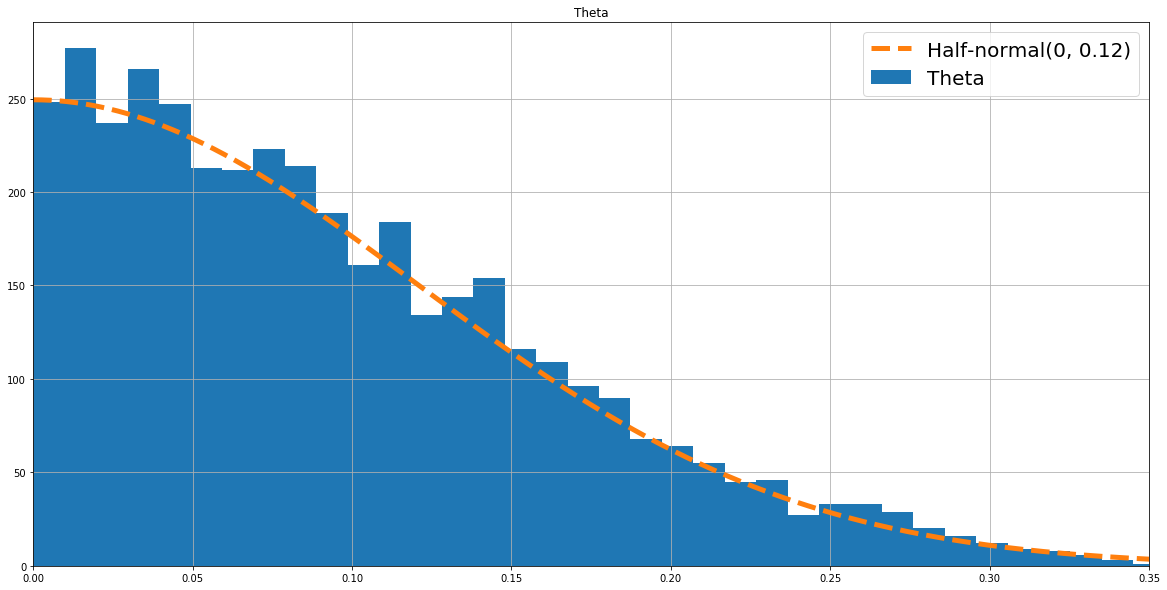

In [50]:
#We plot the histograms.
plt.figure(figsize = [20, 10])
plt.title('Theta')
plt.xlim([0, 0.35])
plt.hist(params.iloc[:, 0], bins = 50, label = 'Theta')
x = np.linspace(0, 0.35, 2000)
plt.plot(x, 75*stats.norm.pdf(x, 0, 0.12), '--', linewidth = 5, label = 'Half-normal(0, 0.12)')
plt.grid()
plt.legend(prop = {'size': 20})
plt.show()

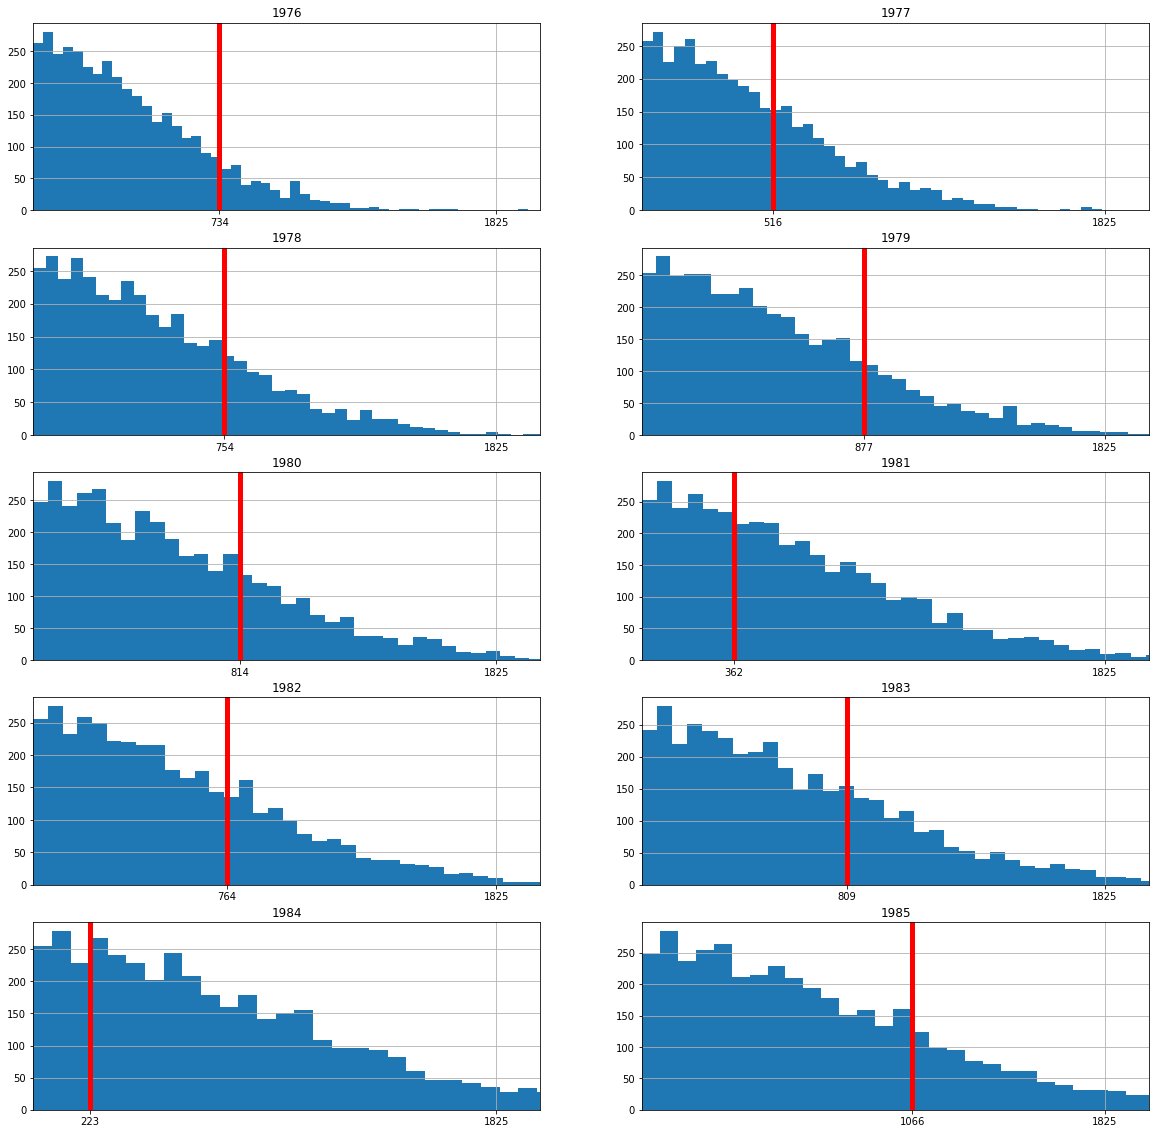

In [51]:
fig, axes = plt.subplots(5, 2, figsize = [20, 20])
for k in range(len(axes.flatten())):
    ax = axes.flatten()[k]
    ax.set_title('{}'.format(data.iloc[k, 0]))
    ax.axvline(data.iloc[k, 2], linewidth = 5, color = 'red')
    ax.set_xlim([0, 2000])
    ax.set_xticks([data.iloc[k, 2], 1825])
    ax.hist(params.iloc[:, k + 1], bins = 50)
    ax.grid()
plt.show()

In [43]:
#Now we make a model with posterior inference.
posterior = """
data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.12);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(miles[k]*theta);
    }
}
"""
posteriorModel = pystan.StanModel(model_code = posterior)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_78cfe52f55399bd0ebc0bd9100bcc6f0 NOW.


In [52]:
dataPosterior = {'M': data.shape[0], 'miles': data['Miles flown [100 mln miles]'], 'y': data['Passenger deaths']}
sim_pcc_posterior = posteriorModel.sampling(data = dataPosterior)
paramsTheta = pd.DataFrame(sim_pcc_posterior.extract()['theta'])
paramsDeaths = pd.DataFrame(sim_pcc_posterior.extract()['y_sim'])
paramsPost = paramsTheta.merge(paramsDeaths, left_index = True, right_index = True)

In [53]:
meanTheta = paramsPost.iloc[:, 0].mean()
confInterval = az.hpd(paramsPost.iloc[:, 0], 0.95)
print('Mean theta: {}, 95% confidence interval: ({}, {})'.format(meanTheta, confInterval[0], confInterval[1]))

Mean theta: 0.1211055077183267, 95% confidence interval: (0.11844525619975914, 0.12419590651525361)


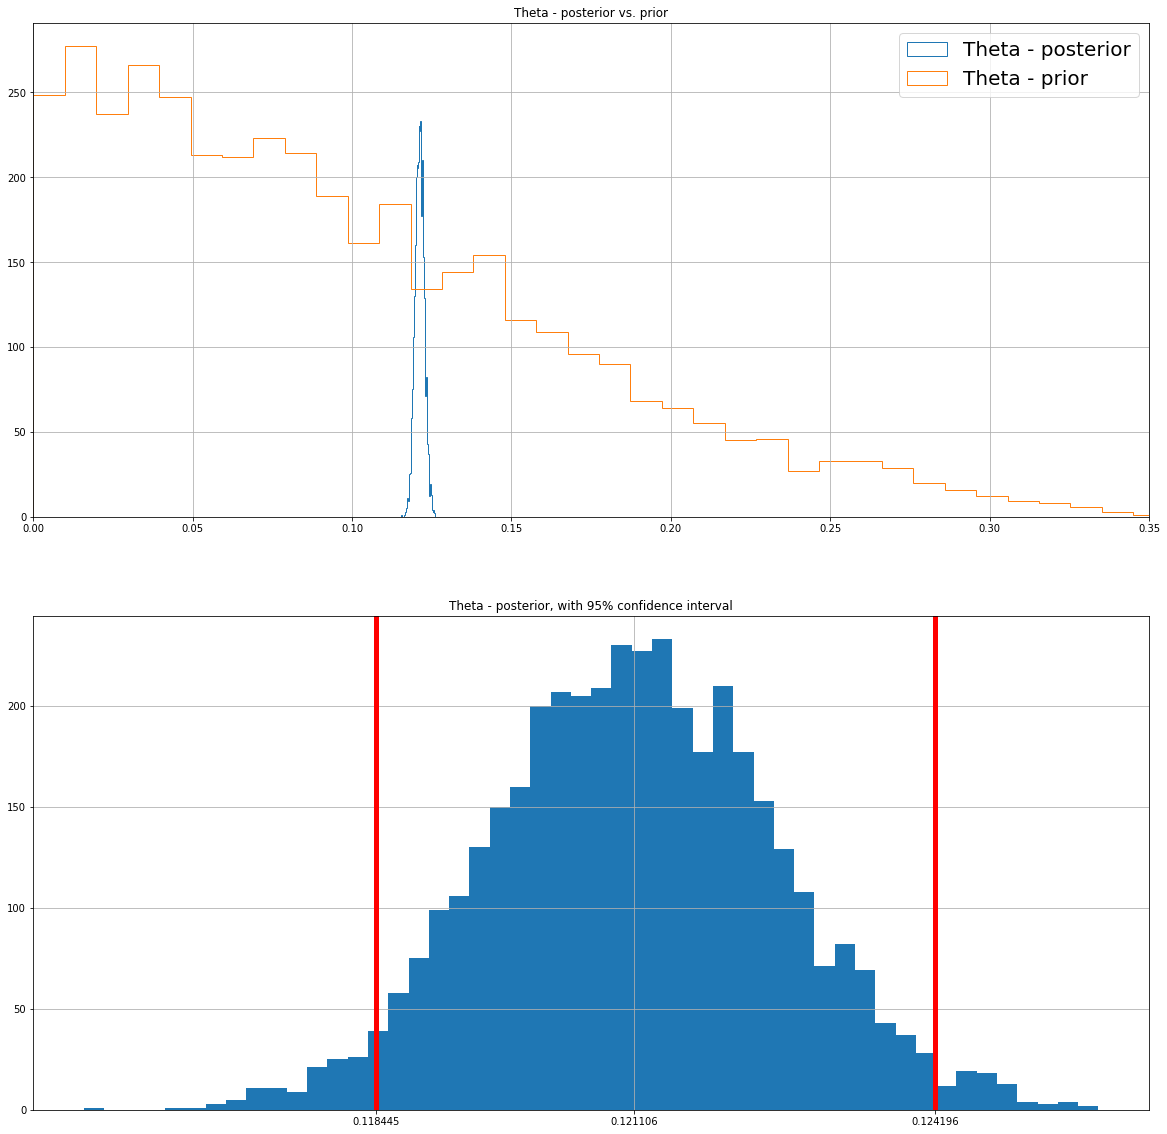

In [57]:
fig, ax = plt.subplots(2, 1, figsize = [20, 20])
ax1 = ax[0]
ax1.set_title('Theta - posterior vs. prior')
ax1.set_xlim([0, 0.35])
ax1.hist(paramsPost.iloc[:, 0], bins = 50, histtype = 'step', label = 'Theta - posterior')
ax1.hist(params.iloc[:, 0], bins = 50, histtype = 'step', label = 'Theta - prior')
ax1.grid()
ax1.legend(prop = {'size': 20})
ax2 = ax[1]
ax2.set_title('Theta - posterior, with 95% confidence interval')
ax2.hist(paramsPost.iloc[:, 0], bins = 50)
ax2.set_xticks([confInterval[0], meanTheta, confInterval[1]])
ax2.axvline(confInterval[0], linewidth = 5, color = 'red')
ax2.axvline(confInterval[1], linewidth = 5, color = 'red')
ax2.grid()
plt.show()

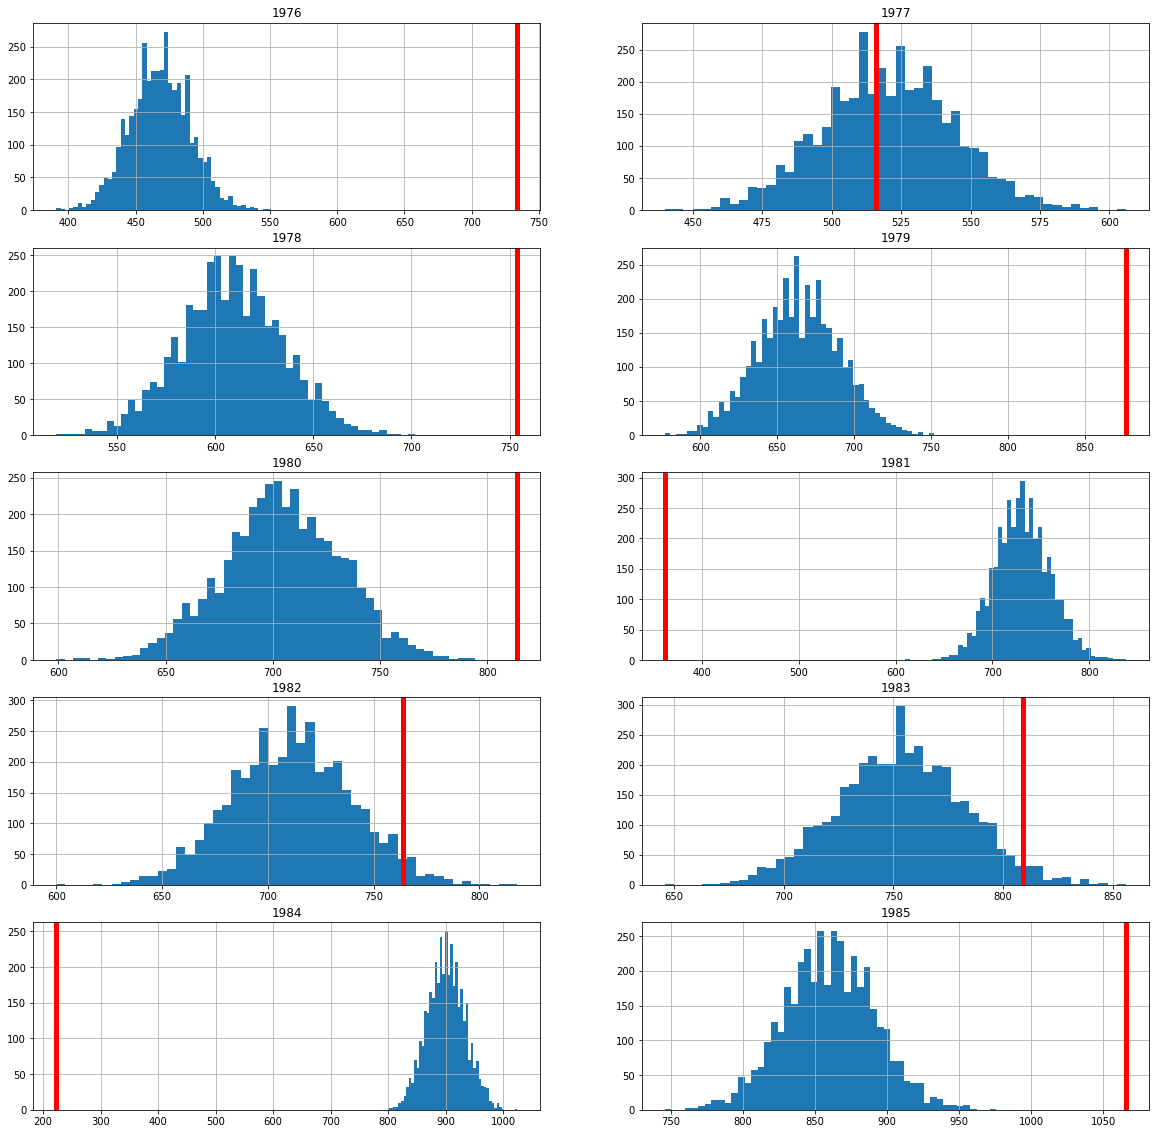

In [59]:
fig, axes = plt.subplots(5, 2, figsize = [20, 20])
for k in range(len(axes.flatten())):
    ax = axes.flatten()[k]
    ax.set_title('{}'.format(data.iloc[k, 0]))
    ax.axvline(data.iloc[k, 2], linewidth = 5, color = 'red')
    ax.hist(paramsPost.iloc[:, k + 1], bins = 50)
    ax.grid()
plt.show()

In [60]:
#Now we will predict the number of passengers' deaths in 1986. Knowing that there were 9100*100 mln miles flown that year,
#we make the next model.
predict1986 = """
data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.12);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y1986 = poisson_rng(9100*theta);
}
"""
predict1986model = pystan.StanModel(model_code = predict1986)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4ce863b728b128540e7a51959baf8c33 NOW.


In [65]:
dataPredict1986 = {'M': data.shape[0], 'miles': data['Miles flown [100 mln miles]'], 'y': data['Passenger deaths']}
sim_pcc_predict1986 = predict1986model.sampling(data = dataPredict1986)
params1986 = sim_pcc_predict1986.extract()['y1986']
meanDeaths = np.mean(params1986)
confIntervalPredict = az.hpd(params1986, 0.95)
print('Mean of predicted passengers\' deaths: {}, 95% confidence interval: ({}, {})'.
     format(meanDeaths, confIntervalPredict[0], confIntervalPredict[1]))

Mean of predicted passengers' deaths: 1100.97375, 95% confidence interval: (1022.0, 1167.0)


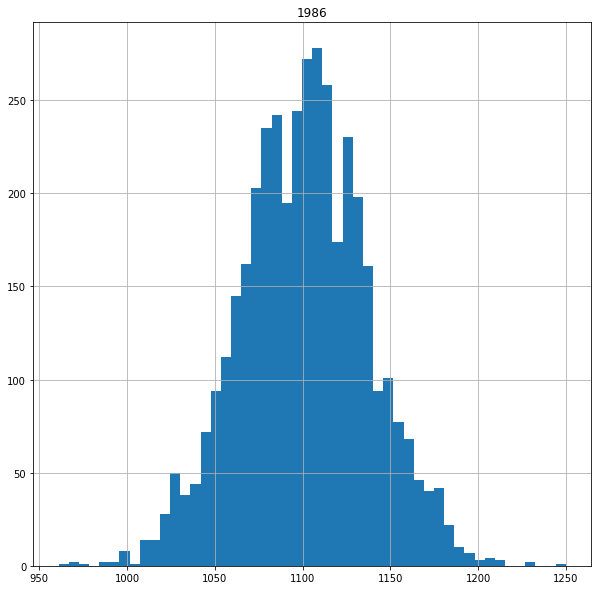

In [67]:
plt.figure(figsize = [10, 10])
plt.title('1986')
plt.hist(params1986, bins = 50)
plt.grid()
plt.show()